## Customer behavior analytics

 The main goals of this project are to calculate and visualize:
- Retention
- Churn
- LTV
- RFM

And also analyze the information received and, based on it, give some business recommendations.

In [45]:
#Import all necessary libraries
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns 
import numpy as np
import datetime as dt

#Adding a visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.1)

#Connecting to the dataset
df = pd.read_csv('online_retail_II.csv')

#Initial data review
print("Shape of dataset:", df.shape)
print("\nColumns:", df.columns)
print("\nInfo:")
print(df.info())
print("\nStatistical summary (numerical columns):")
print(df.describe())   

Shape of dataset: (1067371, 8)

Columns: Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB
None

Statistical summary (numerical columns):
           Quantity         Price    Customer ID
count  1.067371e+06  1.067371e+06  824364.000000
mean   9.938898e+00  4.649388e+00   15324.638504
std  

In [46]:
#Data cleaning and preprocessing
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
df = df.loc[:, ~df.columns.duplicated()]
df['invoicedate'] = pd.to_datetime(df['invoicedate'])
df = df.dropna(subset=['customer_id'])
df = df[df['quantity'] > 0]
df = df[df['price'] > 0]
df['revenue'] = df['quantity'] * df['price']

In [47]:
#Preparing data for cohort analysis
df['invoice_month'] = df['invoicedate'].dt.to_period('M')
first_purchase = df.groupby('customer_id')['invoice_month'].min().reset_index()
first_purchase.columns = ['customer_id', 'cohort_month']
df = df.merge(first_purchase, on='customer_id')

In [48]:
#Adding a cohort index (cohort_index)
def cohort_index(invoice_month, cohort_month):
    return (invoice_month.year - cohort_month.year) * 12 + (invoice_month.month - cohort_month.month) + 1
df['cohort_index'] = df.apply(lambda row: cohort_index(row['invoice_month'], row['cohort_month']), axis = 1)

In [49]:
#Grouping data and counting the number of clients in a cohort
cohort_data = (
    df.groupby(['cohort_month', 'cohort_index'])['customer_id']
    .nunique()
    .reset_index(name='num_customers')
)
#Converting data into a table
cohort_counts = cohort_data.pivot(index='cohort_month', columns='cohort_index', values='num_customers')

In [50]:
#Calculating customer retention rates
cohort_size = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_size, axis=0).round(3)

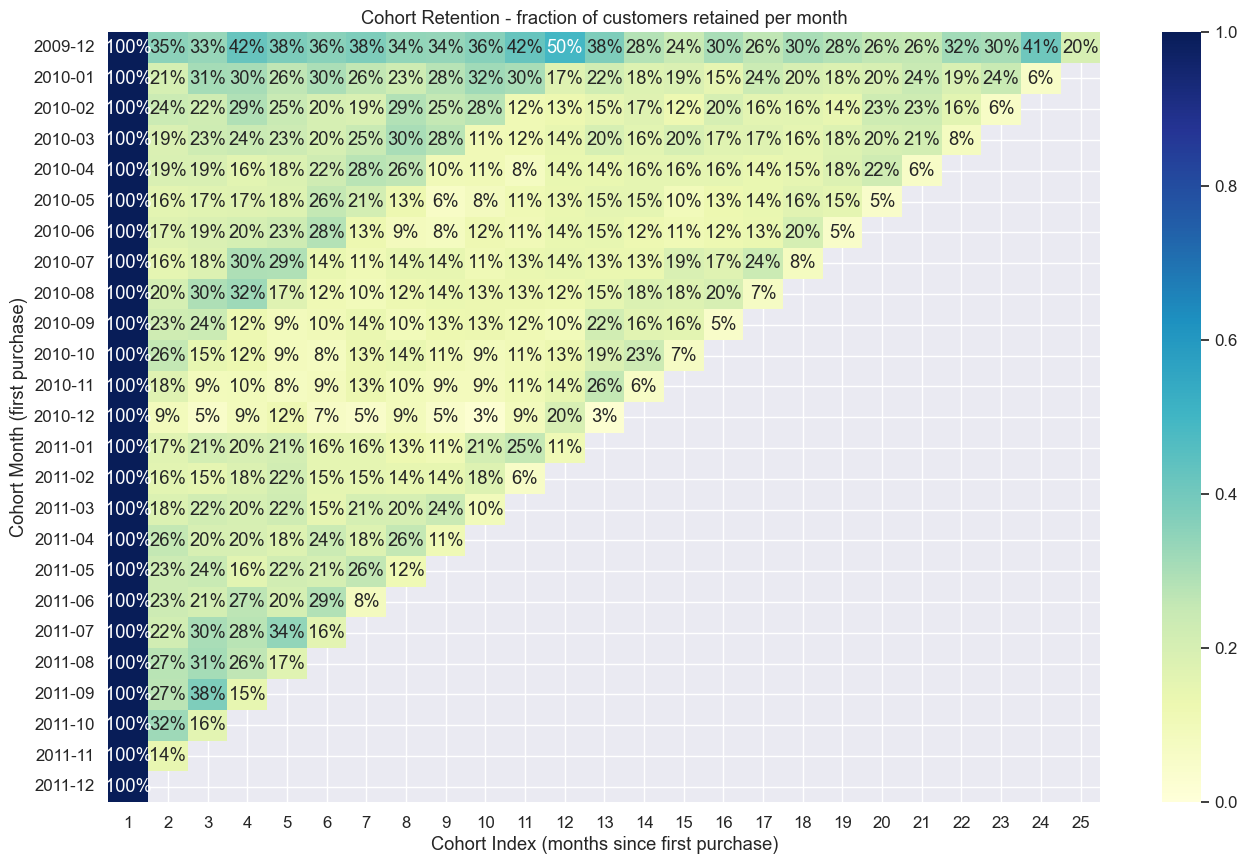

In [51]:
#Visualization of cohort analysis
plt.figure(figsize=(16, 10))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='YlGnBu', vmin=0.0, vmax=1.0)
plt.title('Cohort Retention - fraction of customers retained per month')
plt.ylabel('Cohort Month (first purchase)')
plt.xlabel('Cohort Index (months since first purchase)')
plt.yticks(rotation=0)
plt.savefig('ANALYSIS/PROJECT_2/Charts/Customer_Retention_Chart.png', dpi=300, bbox_inches='tight')
plt.show()

In [52]:
#Calculating retention by year
retention_year = retention.copy()
retention_year['cohortyear'] = retention_year.index.year
yearly_retention = retention_year.groupby('cohortyear').mean(numeric_only=True)

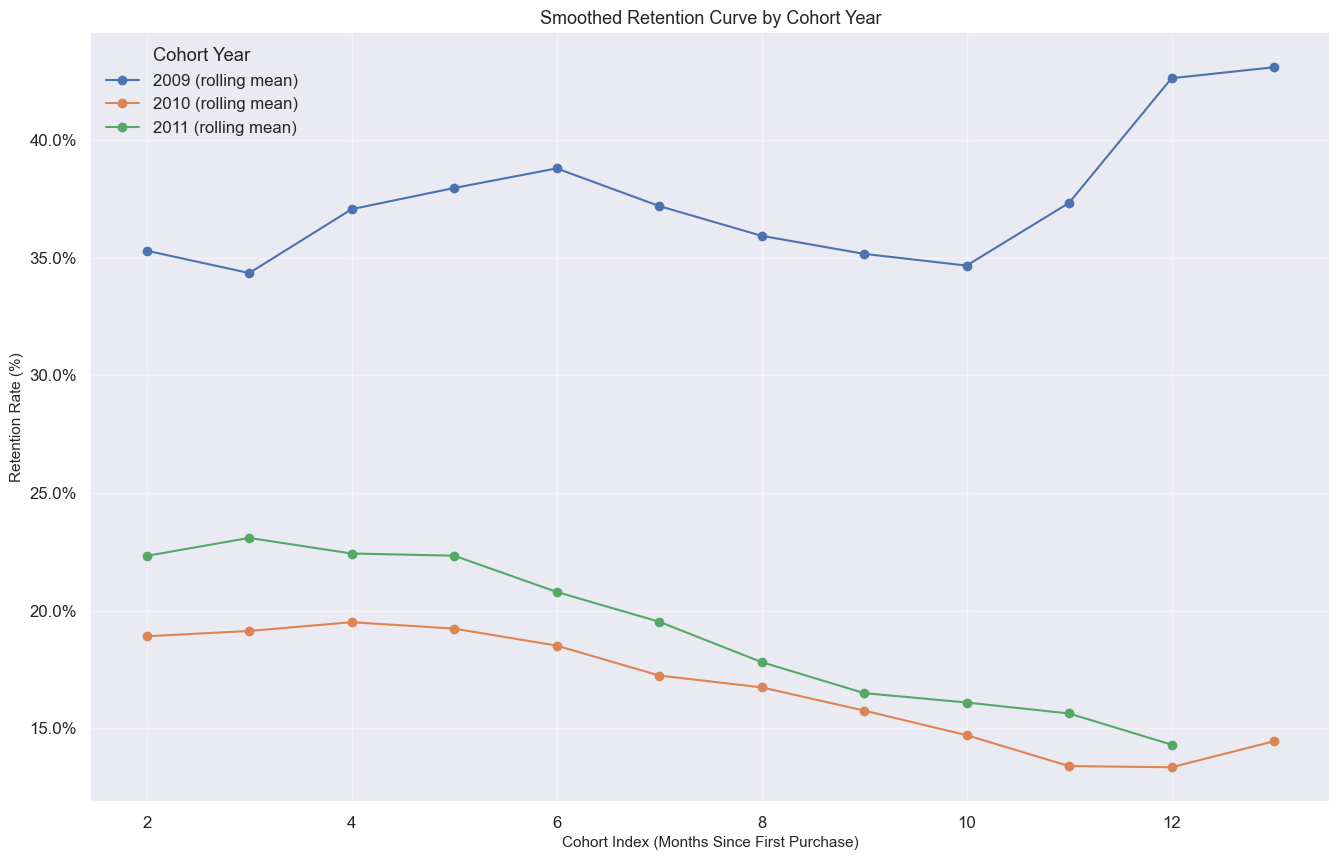

In [53]:
#Visualization of annual retention
plt.figure(figsize=(16,10))

for year in yearly_retention.index:
    data = yearly_retention.loc[year].dropna()
    
    data = data.iloc[1:]

    data = data.iloc[:12]
    
    smooth = data.rolling(window=3, min_periods=1).mean()
    

    smooth_percent = smooth * 100
    
    plt.plot(
        smooth_percent.index,
        smooth_percent.values,
        marker='o',
        label=f'{year} (rolling mean)'
)

plt.title('Smoothed Retention Curve by Cohort Year', fontsize=13)
plt.xlabel('Cohort Index (Months Since First Purchase)', fontsize=11)
plt.ylabel('Retention Rate (%)', fontsize=11)
plt.legend(title='Cohort Year')
plt.grid(True, alpha=0.4)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('ANALYSIS/PROJECT_2/Charts/Customer_Retention_Chart_by_Year.png', dpi=300, bbox_inches='tight')
plt.show()

In [54]:
#Calculating customer churn
churn = 1 - retention

avg_churn = churn.mean().reset_index()
avg_churn.columns =  ['months_since_first_purchase', 'average_churn_rate']
avg_churn = avg_churn.iloc[1:]
avg_churn = avg_churn.iloc[:12]

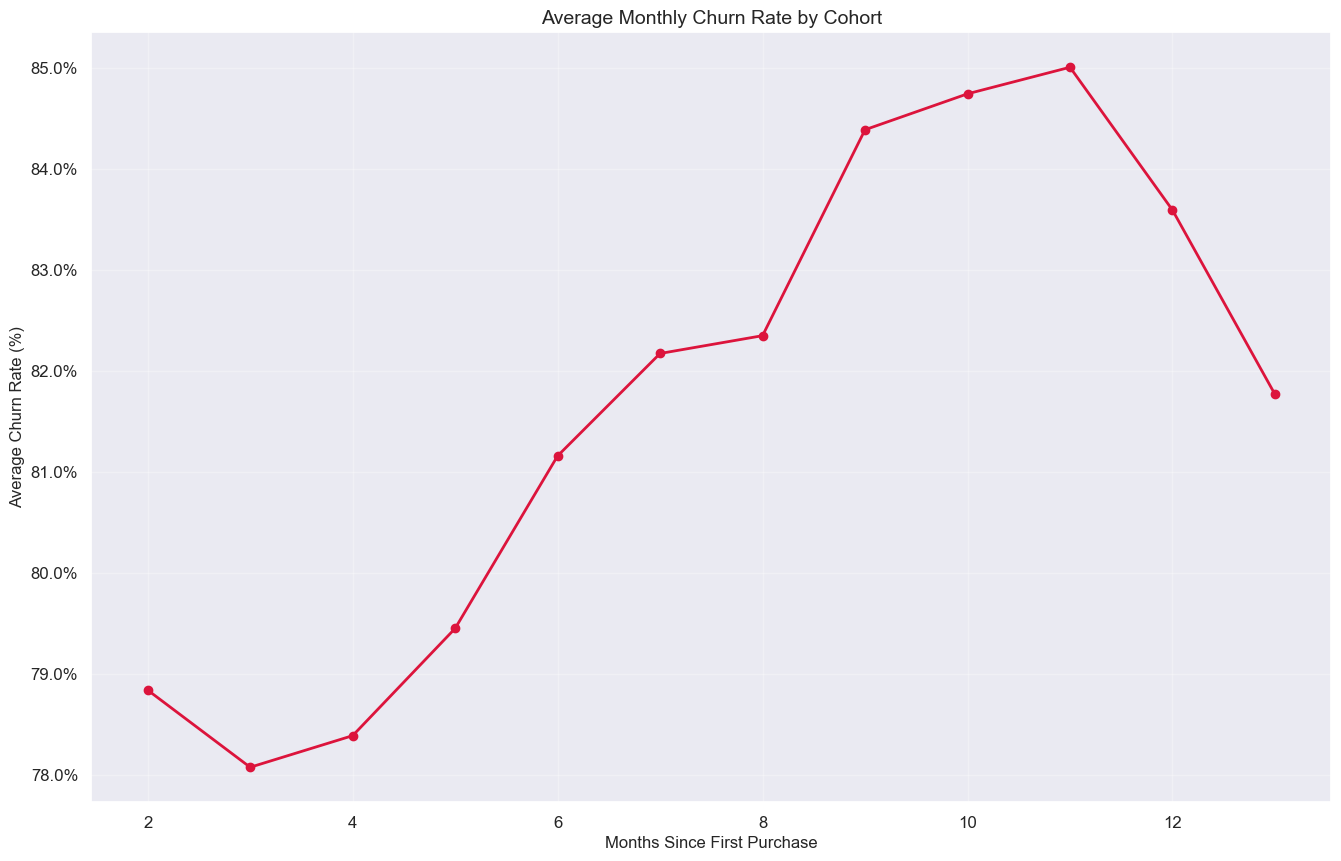

In [55]:
#Visualization customer churn
plt.figure(figsize=(16,10))
plt.plot(
    avg_churn['months_since_first_purchase'],
    avg_churn['average_churn_rate']*100,
    marker='o',
    color='crimson',
    linewidth=2
)

plt.title('Average Monthly Churn Rate by Cohort', fontsize=14)
plt.xlabel('Months Since First Purchase', fontsize=12)
plt.ylabel('Average Churn Rate (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('ANALYSIS/PROJECT_2/Charts/Customer_Churn_Chart.png', dpi=300, bbox_inches='tight')
plt.show()

In [56]:
#Lifetime Value
cohort_revenue = (
    df.groupby(['cohort_month', 'cohort_index'])['revenue']
    .sum()
    .reset_index()
)

cohort_size = cohort_counts.iloc[:, 0] 
cohort_size = cohort_size.reset_index().rename(columns={cohort_size.name: 'cohort_size'})

cohort_revenue = cohort_revenue.merge(cohort_size, on='cohort_month')

cohort_revenue['ltv'] = cohort_revenue['revenue'] / cohort_revenue['cohort_size']

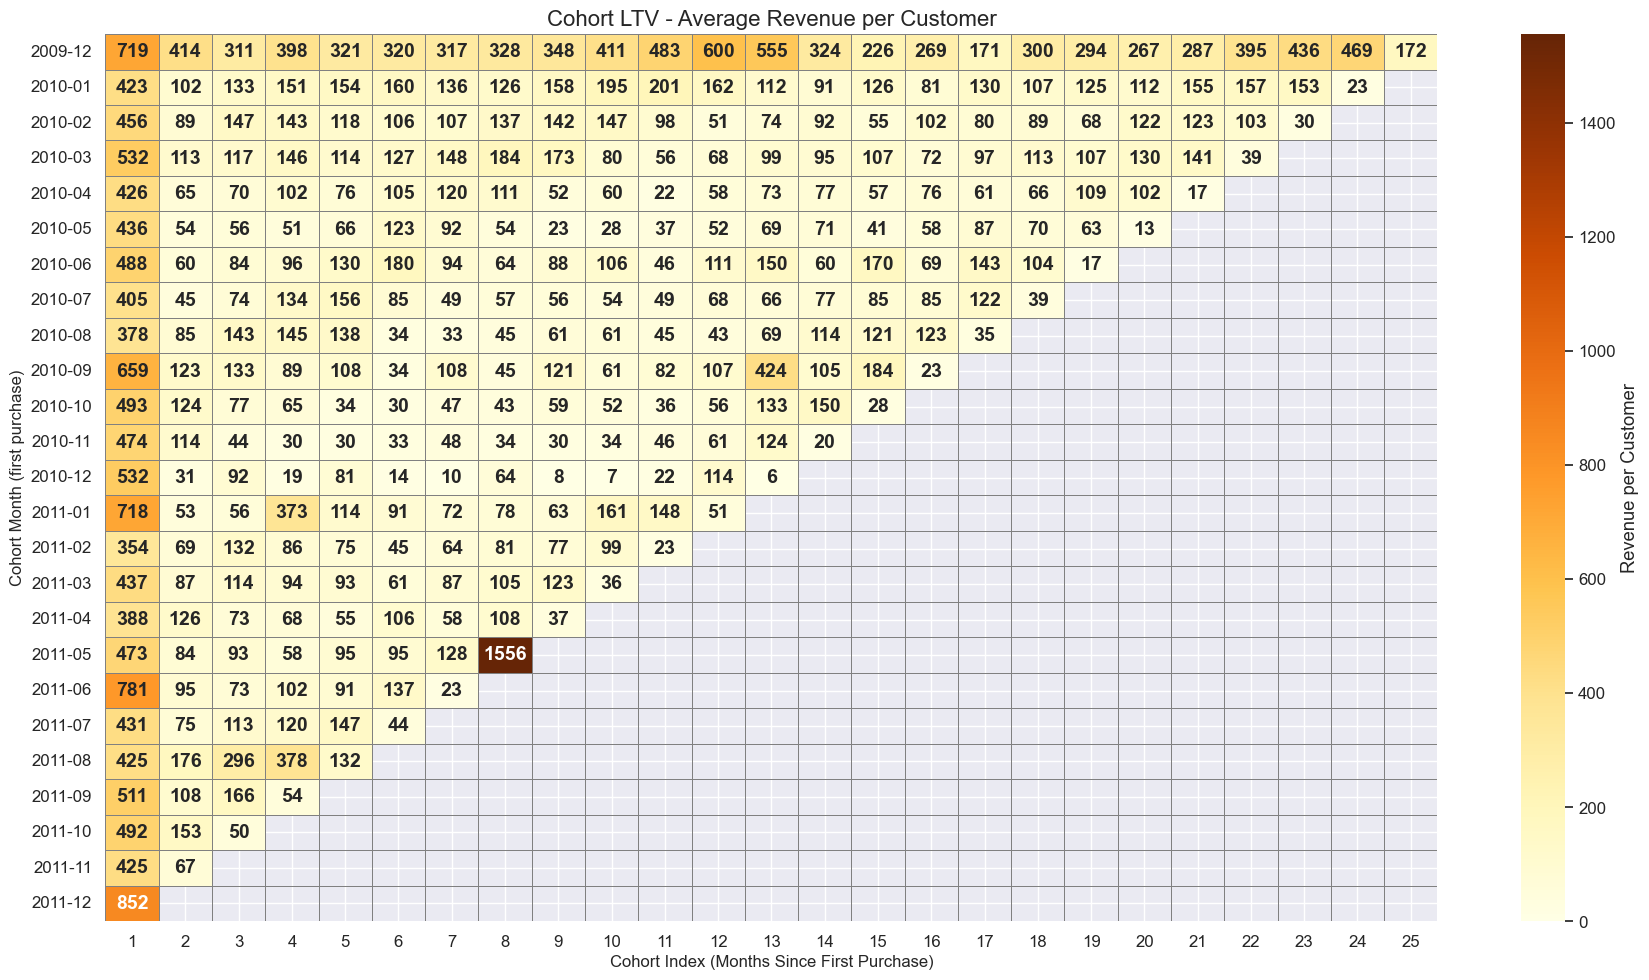

In [57]:
#Visualization LTV
ltv_matrix = cohort_revenue.pivot(index='cohort_month', columns='cohort_index', values='ltv')

plt.figure(figsize=(18, 10))  

sns.heatmap(
    ltv_matrix,
    annot=True,                
    fmt='.0f',                 
    cmap='YlOrBr',            
    vmin=0,                    
    vmax=ltv_matrix.max().max(),
    annot_kws={"size": 14, "weight": "bold"},  
    linewidths=0.5,            
    linecolor='gray',          
    cbar_kws={'label': 'Revenue per Customer'} 
)

plt.title('Cohort LTV - Average Revenue per Customer', fontsize=16)
plt.ylabel('Cohort Month (first purchase)', fontsize=12)
plt.xlabel('Cohort Index (Months Since First Purchase)', fontsize=12)
plt.yticks(rotation=0)         
plt.xticks(rotation=0)
plt.tight_layout()             
plt.savefig('ANALYSIS/PROJECT_2/Charts/Chart_LTV.png', dpi=300, bbox_inches='tight')
plt.show()

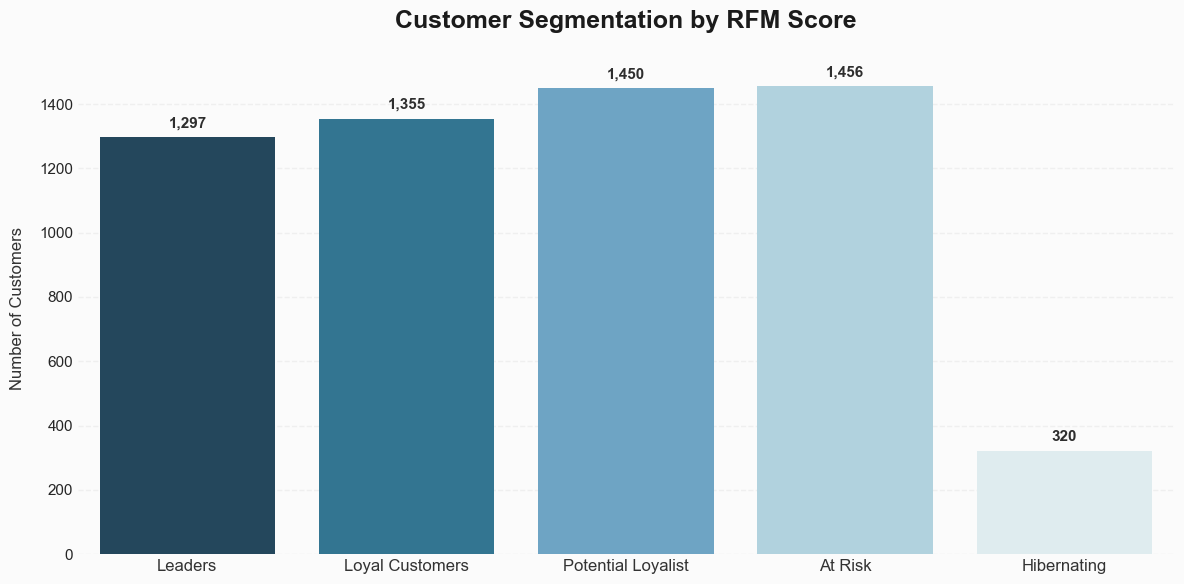

In [58]:
#RFM analysis and its visualization
snapshot_date = df['invoicedate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('customer_id').agg({
    'invoicedate': lambda x: (snapshot_date - x.max()).days,
    'invoice': 'nunique',
    'revenue': 'sum'
}).reset_index()

rfm.rename(columns={'invoicedate': 'recency', 'invoice': 'frequency', 'revenue': 'monetary'}, inplace=True)

rfm['r_rank'] = pd.qcut(rfm['recency'], 5, labels=[5,4,3,2,1])
rfm['f_rank'] = pd.qcut(rfm['frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['m_rank'] = pd.qcut(rfm['monetary'], 5, labels=[1,2,3,4,5])

rfm[['r_rank', 'f_rank', 'm_rank']] = rfm[['r_rank', 'f_rank', 'm_rank']].astype(int)

rfm['rfm_score'] = rfm[['r_rank', 'f_rank', 'm_rank']].sum(axis=1)

def segment_customer(score):
    if score >= 13:
        return 'leaders'
    if score >= 10:
        return 'loyal customers'
    if score >= 7:
        return 'potential loyalist'
    if score >= 4:
        return 'at risk'
    else:
        return 'hibernating'

rfm['segment'] = rfm['rfm_score'].astype(int).apply(segment_customer)

rfm_counts = rfm['segment'].value_counts().reset_index()
rfm_counts.columns = ['Segment', 'Number of Customers']

segment_order = ['leaders', 'loyal customers', 'potential loyalist', 'at risk', 'hibernating']
rfm_counts['Segment'] = pd.Categorical(rfm_counts['Segment'], categories=segment_order, ordered=True)
rfm_counts = rfm_counts.sort_values('Segment')

sns.set_theme(style="white")
plt.style.use("seaborn-v0_8-white")

fig, ax = plt.subplots(figsize=(12, 6))

colors = ["#1B4965", "#247BA0", "#5FA8D3", "#A9D6E5", "#DCEEF2"]

bars = sns.barplot(
    data=rfm_counts,
    x='Segment',
    y='Number of Customers',
    hue='Segment',
    palette=colors,
    dodge=False,
    legend=False,
    edgecolor='none'
)

for p in bars.patches:
    bars.annotate(
        f'{int(p.get_height()):,}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='bottom',
        fontsize=11,
        color='#2E2E2E',
        fontweight='bold',
        xytext=(0, 5),
        textcoords='offset points'
)

ax.set_title('Customer Segmentation by RFM Score', fontsize=18, fontweight='bold', pad=25, color='#1B1B1B')
ax.set_xlabel('')
ax.set_ylabel('Number of Customers', fontsize=12, labelpad=10, color='#333333')

ax.set_xticks(range(len(rfm_counts['Segment'])))
ax.set_xticklabels(
    [seg.title() for seg in rfm_counts['Segment']],
    fontsize=12,
    color='#333333'
)

ax.grid(axis='y', linestyle='--', alpha=0.25)
sns.despine(left=True, bottom=True)

fig.patch.set_facecolor('#FBFBFB')
ax.set_facecolor('#FBFBFB')

plt.tight_layout()
plt.savefig('ANALYSIS/PROJECT_2/Charts/Chart_RFM.png', dpi=300, bbox_inches='tight')
plt.show()

In [59]:
#Saving the modified dataset
df.to_csv('online_retail_II.csv', index=False)

## Conclusions and business recommendations

The company has seen a downward trend and a significant decline in performance compared to its first year of operation, as indicated by the following metrics:

- __Retention__ - Retention of clients attracted in __2009 remained stable at 30-40%__ in some months reaching 50%, which indicates high customer loyalty.
In __subsequent years, retention remained at 10-15%__, indicating a decline in customer loyalty, but it is worth noting that in the __last months of 2011, retention again increased to 25-30%__. It can also be noted that around the 6th month, there is a significant drop in retention, based on which it is recommended to conduct customer reactivation campaigns.

- __Churn__ - The average customer churn graph indicates that the __peak customer loss occurs between months 6 and 10__, with a slight decline in subsequent months, which confirms the data obtained from the retention analysis.


- __LTV__ - It can be seen that clients acquired at the __end of 2009 demonstrate the greatest loyalty__, generating stable profits throughout their entire life cycle. Clients acquired at the beginning of 2010, while still generating stable profits, experienced a significant drop in revenue and activity, with subsequent years showing an even greater decline. It's also worth paying attention to clients acquired in __May 2011__. Although they generally generate relatively small revenues, there is an anomalous peak in the 8th month, which is significantly higher than all other months. This anomaly could be either a mistake or a __key to further profit growth__, so it's worth paying attention to the company's actions during that period.

  
- __RFM__ - The first thing worth paying attention to is the __largest and almost equal “At risk” and “Potential loyalist”__ categories they offer significant profit potential if properly revived. It's also worth paying attention to the __"Leaders" - they account for ~15%__ and generate the most profit. It's worth introducing additional promotions specifically aimed at this category of clients.